In [1]:
import pandas as pd
import pickle
import numpy as np
import sys
sys.path.insert(0,'../')
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import copy

# Load and prepare data

Deep check

In [2]:
file = open('../resources/memory1', 'rb')
memory = pickle.load(file)

file = open('../resources/memory2', 'rb')
memory2 = pickle.load(file)

memory = memory.ltmemory
memory2 = memory2.ltmemory

memory+=memory2

print('number of samples:',len(memory))

number of samples: 126077


In [3]:
result = map(lambda x: x['result'], memory) 

result = list(result)

states = map(lambda x: x['state'].reshape(384,), memory) 

states = list(states)

y = np.array(result)

X = np.array(states)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
y_train = y_train>0
y_train = y_train.astype(int)
y_test = y_test>0
y_test = y_test.astype(int)

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# RF baseline

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

print('accuracy', accuracy_score(y_test, y_pred))

y_pred = clf.predict_proba(X_test)

print('auc',roc_auc_score(y_test, y_pred[:,1]))

print('mae',mean_absolute_error(y_test, y_pred[:,1]))

# DNN

In [ ]:
    params={
        'epochs':100, 'batch_size':[32], 'shuffle':[True], 
        'activation_hidden':['elu'], 'activation':['sigmoid'], 'optimizer':['adam'],
    'architectures':[

        [[300,0.0],[600,0.000001],['dropout',0.2],[400,0.000001],['dropout',0.4],[200,0.000001],['dropout',0.5],[100,0.0]],

    ]} 
    best_model_acc = None
    best_acc = 0
    best_par_acc = []
    best_model_mae = None
    best_mae = 1
    best_par_mae = []
    dict_grid = {}
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    for bs in params['batch_size']:
        for s in params['shuffle']:
            for o in params['optimizer']:
                for ah in params['activation_hidden']:
                    for a in params['activation']:
                        for arch in params['architectures']:
                            model = keras.Sequential()
                            for layer in arch:
                                if layer[0] == 'dropout':
                                    model.add(keras.layers.Dropout(layer[1]))
                                else:
                                    model.add(keras.layers.Dense(layer[0], activation=ah,
                                         kernel_regularizer=keras.regularizers.l2(l=layer[1]) ))
                            model.add(keras.layers.Dense(1, activation=a))
                            model.compile(optimizer=o,loss='binary_crossentropy',metrics=['mae'])
                            for e in range(params['epochs']):
                                
#                                 with tf.device('/GPU:0'):
                                model.fit(X_tr,y_tr, epochs=1,batch_size=bs,shuffle=s)

                                y_pred = model.predict_classes(X_val)

                                acc = accuracy_score(y_val, y_pred)

                                y_pred = model.predict(X_val)

                                mae = mean_absolute_error(y_val, y_pred)
                                
                                print(e,arch,bs,s,o,ah )
                                print('acc',acc )
                                print('mae',mae )
                                
                                if acc > best_acc:
                                    best_acc = acc
                                    best_par_acc = [e,arch,bs,s,o,ah]
                                    best_model_acc = keras.Sequential()
                                    for layer in arch:
                                        if layer[0] == 'dropout':
                                            best_model_acc.add(keras.layers.Dropout(layer[1]))
                                        else:
                                            best_model_acc.add(keras.layers.Dense(layer[0], activation=ah,
                                                 kernel_regularizer=keras.regularizers.l2(l=layer[1]) ))
                                    best_model_acc.add(keras.layers.Dense(1, activation=a))
                                    best_model_acc.compile(optimizer=o,loss='binary_crossentropy',metrics=['mae'])
                                    best_model_acc.build(input_shape=(None,384,))
                                    best_model_acc.set_weights(model.get_weights()) 
                                if mae < best_mae:
                                    best_mae = mae
                                    best_par_mae = [e,arch,bs,s,o,ah]
                                    best_model_mae = keras.Sequential()
                                    for layer in arch:
                                        if layer[0] == 'dropout':
                                            best_model_mae.add(keras.layers.Dropout(layer[1]))
                                        else:
                                            best_model_mae.add(keras.layers.Dense(layer[0], activation=ah,
                                                 kernel_regularizer=keras.regularizers.l2(l=layer[1]) ))
                                    best_model_mae.add(keras.layers.Dense(1, activation=a))
                                    best_model_mae.compile(optimizer=o,loss='binary_crossentropy',metrics=['mae'])
                                    best_model_mae.build(input_shape=(None,384,))
                                    best_model_mae.set_weights(model.get_weights()) 
                        
                                
                                    
                                    
                            

In [ ]:
print(best_acc)
print(best_mae)

In [ ]:
print(best_par_acc)
print(best_par_mae)

In [ ]:
y_pred = best_model_mae.predict_classes(X_val)

print('acc',accuracy_score(y_val, y_pred))

y_pred = best_model_mae.predict(X_val)

print('auc',roc_auc_score(y_val, y_pred))

print('mae',mean_absolute_error(y_val, y_pred))

plt.plot(y_pred)

In [ ]:
y_pred = best_model_mae.predict_classes(X_test)

print('acc',accuracy_score(y_test, y_pred))

y_pred = best_model_mae.predict(X_test)

print('auc',roc_auc_score(y_test, y_pred))

print('mae',mean_absolute_error(y_test, y_pred))

plt.plot(y_pred)

In [ ]:
pickle.dump()

other attempts

In [ ]:
# sgd = tf.keras.optimizers.SGD(lr=0.1)

In [ ]:
# model = keras.Sequential()
# model.add(keras.layers.Dense(100, activation='sigmoid', input_dim=384,
#                              kernel_regularizer=keras.regularizers.l2(l=0.00001) ))
# model.add(keras.layers.Dense(200, activation='sigmoid', input_dim=100,
#                             kernel_regularizer=keras.regularizers.l2(l=0.00001) ))
# model.add(keras.layers.Dense(200, activation='sigmoid', input_dim=100,
#                             kernel_regularizer=keras.regularizers.l2(l=0.00001) ))
# model.add(keras.layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mae'])



In [ ]:
# # print(c)
# with tf.device('/GPU:0'):
#     model.fit(X_train,y_train, epochs=30,batch_size=128,shuffle=False)

valid

In [ ]:
# _, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# y_pred = model.predict_classes(X_val)

# print('acc',accuracy_score(y_val, y_pred))

# y_pred = model.predict(X_val)

# print('auc',roc_auc_score(y_val, y_pred))

# print('mae',mean_absolute_error(y_val, y_pred))

# plt.plot(y_pred)

test

In [ ]:
# y_pred = model.predict_classes(X_test)

# print('acc',accuracy_score(y_test, y_pred))

# y_pred = model.predict(X_test)

# print('auc',roc_auc_score(y_test, y_pred))

# print('mae',mean_absolute_error(y_test, y_pred))

# plt.plot(y_pred)

In [ ]:
print(model.summary())

# Attempt with position

In [ ]:
positions = list(map(lambda x: list(x['current_position']), memory)) 


positions = np.array(positions)

X = np.concatenate((X, positions), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train>0
y_train = y_train.astype(int)
y_test = y_test>0
y_test = y_test.astype(int)

In [ ]:
X_train[0]

# RF baseline

In [ ]:
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

print('accuracy', accuracy_score(y_test, y_pred))

y_pred = clf.predict_proba(X_test)

print('auc',roc_auc_score(y_test, y_pred[:,1]))

print('mae',mean_absolute_error(y_test, y_pred[:,1]))

# DNN

In [ ]:
    params={
        'epochs':20, 'batch_size':[32], 'shuffle':[True], 
        'activation_hidden':['elu','linear'], 'activation':['sigmoid'], 'optimizer':['adam','adagrad'],
    'architectures':[

        [[300,0.0],[600,0.000001],['dropout',0.2],[400,0.000001],['dropout',0.4],[200,0.000001],['dropout',0.5],[100,0.0]],
        [[400,0.0],[800,0.000001],['dropout',0.5],[400,0.000001],['dropout',0.5],[200,0.000001],['dropout',0.5],[100,0.0]],
        [[200,0.0],[100,0.000001],[50,0.000001],[100,0.000001],['dropout',0.2],[50,0.0]],

    ]} 
    best_model_acc = None
    best_acc = 0
    best_par_acc = []
    best_model_mae = None
    best_mae = 1
    best_par_mae = []
    dict_grid = {}
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    for bs in params['batch_size']:
        for s in params['shuffle']:
            for o in params['optimizer']:
                for ah in params['activation_hidden']:
                    for a in params['activation']:
                        for arch in params['architectures']:
                            model = keras.Sequential()
                            for layer in arch:
                                if layer[0] == 'dropout':
                                    model.add(keras.layers.Dropout(layer[1]))
                                else:
                                    model.add(keras.layers.Dense(layer[0], activation=ah,
                                         kernel_regularizer=keras.regularizers.l2(l=layer[1]) ))
                            model.add(keras.layers.Dense(1, activation=a))
                            model.compile(optimizer=o,loss='binary_crossentropy',metrics=['mae'])
                            for e in range(params['epochs']):
                                
#                                 with tf.device('/GPU:0'):
                                model.fit(X_tr,y_tr, epochs=1,batch_size=bs,shuffle=s)

                                y_pred = model.predict_classes(X_val)

                                acc = accuracy_score(y_val, y_pred)

                                y_pred = model.predict(X_val)

                                mae = mean_absolute_error(y_val, y_pred)
                                
                                print(e,arch,bs,s,o,ah )
                                print('acc',acc )
                                print('mae',mae )
                                
                                if acc > best_acc:
                                    best_acc = acc
                                    best_par_acc = [e,arch,bs,s,o,ah]
                                    best_model_acc = keras.Sequential()
                                    for layer in arch:
                                        if layer[0] == 'dropout':
                                            best_model_acc.add(keras.layers.Dropout(layer[1]))
                                        else:
                                            best_model_acc.add(keras.layers.Dense(layer[0], activation=ah,
                                                 kernel_regularizer=keras.regularizers.l2(l=layer[1]) ))
                                    best_model_acc.add(keras.layers.Dense(1, activation=a))
                                    best_model_acc.compile(optimizer=o,loss='binary_crossentropy',metrics=['mae'])
                                    best_model_acc.build(input_shape=(None,386,))
                                    best_model_acc.set_weights(model.get_weights()) 
                                if mae < best_mae:
                                    best_mae = mae
                                    best_par_mae = [e,arch,bs,s,o,ah]
                                    best_model_mae = keras.Sequential()
                                    for layer in arch:
                                        if layer[0] == 'dropout':
                                            best_model_mae.add(keras.layers.Dropout(layer[1]))
                                        else:
                                            best_model_mae.add(keras.layers.Dense(layer[0], activation=ah,
                                                 kernel_regularizer=keras.regularizers.l2(l=layer[1]) ))
                                    best_model_mae.add(keras.layers.Dense(1, activation=a))
                                    best_model_mae.compile(optimizer=o,loss='binary_crossentropy',metrics=['mae'])
                                    best_model_mae.build(input_shape=(None,386,))
                                    best_model_mae.set_weights(model.get_weights()) 

In [ ]:
print(best_acc)
print(best_mae)

In [ ]:
best_model_mae.predict(X_train)

In [ ]:
y_pred = best_model_mae.predict_classes(X_test)

print('acc',accuracy_score(y_test, y_pred))

y_pred = best_model_mae.predict(X_test)

print('auc',roc_auc_score(y_test, y_pred))

print('mae',mean_absolute_error(y_test, y_pred))

print('mse', mean_squared_error(y_test, y_pred))

plt.plot(y_pred)

In [ ]:
best_model_mae.save('my_model.h5') 

In [ ]:
best_model_mae = tf.keras.models.load_model('../resources/DNN_deep_check.h5')

In [ ]:
best_model_mae.summary()

In [ ]:
from keras.utils import plot_model
plot_model(best_model_mae, to_file='model.png')

Residual CNN

In [22]:
positions = list(map(lambda x: list(x['current_position']), memory)) 


positions = np.array(positions)

In [23]:
X = np.array(tf.cast(X, tf.float32))
positions = np.array(tf.cast(positions, tf.float32))
y = np.array(tf.cast(y, tf.float32))

In [24]:
X = np.array( [a.reshape(48,8,1) for a in X])

In [25]:
y

array([-1.,  1., -1., ..., -1.,  1., -1.], dtype=float32)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

positions_tr, positions_tst, y_train, y_test = train_test_split(positions, y, test_size=0.2, shuffle=False)

positions_tr, positions_val, y_train, y_val = train_test_split(positions_tr, y_train, test_size=0.2, shuffle=False)

In [35]:
y_train = y_train>0
y_train = y_train.astype(int)
y_val = y_val>0
y_val = y_val.astype(int)
y_test = y_test>0
y_test = y_test.astype(int)

In [28]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

In [29]:
main_input = Input(shape=(48,8,1),  name='main_input')

x = Conv2D(384, (12, 3), padding='same',activation='relu')(main_input)
x = Conv2D(384, (8, 2), padding='same',activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001))(x)
x = MaxPooling2D((4,1))(x)
x = Dropout(0.1)(x)
x = Conv2D(96, (3, 3), padding='same',activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001))(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
auxiliary_input = Input(shape=(2,), name='aux_input')
x = keras.layers.concatenate([x, auxiliary_input])
x = Dense(300, activation='elu', kernel_regularizer=keras.regularizers.l2(l=0.0001))(x)
x = Dropout(0.2)(x)
x = Dense(400, activation='elu', kernel_regularizer=keras.regularizers.l2(l=0.0001))(x)
x = Dropout(0.2)(x)
x = Dense(200, activation='elu', kernel_regularizer=keras.regularizers.l2(l=0.0001))(x)
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

model.compile(optimizer='adam', loss='binary_crossentropy', metric=['mae'])

In [ ]:
    for e in range(100):
        model.fit([X_train, positions_tr], [y_train], epochs=1, batch_size=32, verbose=1)
    #     y_pred = model.predict_classes([X_val, positions_val])

    y_pred = model.predict([X_val, positions_val])

    mae = mean_absolute_error(y_val, y_pred)   
    
    print(mae)

Train on 80688 samples
80688/80688 [==============================] - 276s 3ms/sample - loss: 0.6817
Train on 80688 samples
80688/80688 [==============================] - 277s 3ms/sample - loss: 0.6782
Train on 80688 samples
80688/80688 [==============================] - 277s 3ms/sample - loss: 0.6768
Train on 80688 samples
80688/80688 [==============================] - 277s 3ms/sample - loss: 0.6757
Train on 80688 samples
80688/80688 [==============================] - 277s 3ms/sample - loss: 0.6757
Train on 80688 samples
57408/80688 [====================>.........] - ETA: 1:19 - loss: 0.6764

In [39]:
    y_pred = model.predict([X_test, positions_tst])

    mae = mean_absolute_error(y_test, y_pred)   
    
    print(mae)

0.4827240758036561


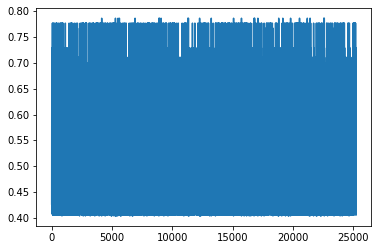

In [40]:
plt.plot(y_pred)